# Model Comparison and Ensemble
This notebook compares Logistic Regression, XGBoost, and LightGBM, and demonstrates a simple ensemble strategy.

In [9]:
# Imports
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [10]:
# Load data
df = pd.read_csv('../outputs/woe_train_data.csv')
X = df.drop(columns='SeriousDlqin2yrs')
y = df['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Train Models

In [11]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

/Users/yahuanshi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
# LightGBM
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7046, number of negative: 97954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067105 -> initscore=-2.632038
[LightGBM] [Info] Start training from score -2.632038


LGBMClassifier()

## Evaluate Models

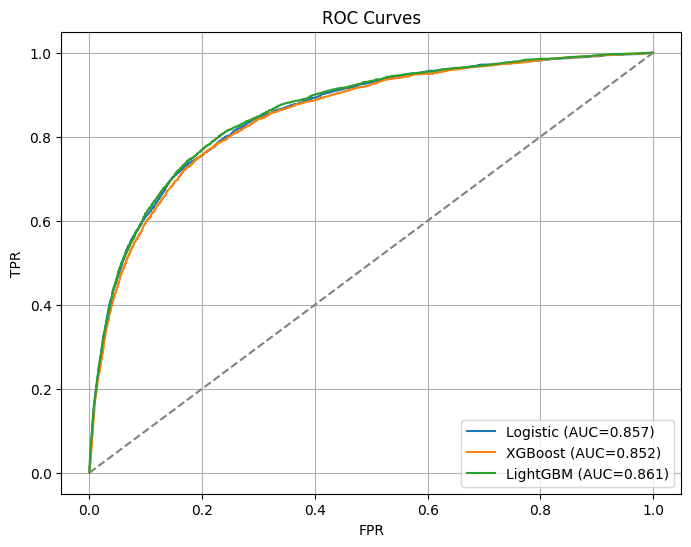

In [14]:
def plot_roc(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title("ROC Curves")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid(True)
    plt.show()

models = {'Logistic': lr, 'XGBoost': xgb, 'LightGBM': lgb}
plot_roc(models, X_test, y_test)

## Simple Ensemble (Average Probability)

In [15]:
# Average predicted probabilities
lr_p = lr.predict_proba(X_test)[:,1]
xgb_p = xgb.predict_proba(X_test)[:,1]
lgb_p = lgb.predict_proba(X_test)[:,1]

avg_p = (lr_p + xgb_p + lgb_p) / 3
ensemble_auc = roc_auc_score(y_test, avg_p)
print(f"Ensemble AUC: {ensemble_auc:.4f}")

Ensemble AUC: 0.8603


## Save Best Model

In [16]:
# Save XGBoost as example
joblib.dump(xgb, '../models/xgboost_model.pkl')

['../models/xgboost_model.pkl']

In [17]:
# Automatically save the best model based on AUC
model_dict = {
    'logistic_model': lr,
    'xgboost_model': xgb,
    'lightgbm_model': lgb
}
auc_dict = {
    name: roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    for name, model in model_dict.items()
}
best_model_name = max(auc_dict, key=auc_dict.get)
best_model = model_dict[best_model_name]

# Save best model
joblib.dump(best_model, f'../models/{best_model_name}.pkl')
print(f"Saved best model: {best_model_name} with AUC={auc_dict[best_model_name]:.4f}")

Saved best model: lightgbm_model with AUC=0.8607
